In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skl_preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from statistics import mode
import random
from math import log2
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Data Preprocessing

In [2]:
def preprocess_data(data):
    relevant_data = data[["release_speed", "release_pos_x", "release_pos_z", "release_pos_y", "release_spin_rate", "vx0", "vy0", "vz0", "ax", "ay", "az", "pfx_x", "pfx_z", "spin_axis", "pitch_number", "zone", "p_throws", "balls", "strikes", "pitch_type"]]
    
    relevant_data = relevant_data.dropna()
    relevant_data['p_throws'] = (relevant_data['p_throws'] == 'R').astype(int)
    
    return relevant_data

In [3]:
raw_input_data = pd.read_csv('data/Statcast_2021.csv')
df = preprocess_data(raw_input_data)
df.head()

,release_speed,release_pos_x,release_pos_z,release_pos_y,release_spin_rate,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,spin_axis,pitch_number,zone,p_throws,balls,strikes,pitch_type
0,92.3,1.40,6.80,54.03,2330.0,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,0.69,1.38,148.0,4,1.0,0,1,2,FF
1,80.6,1.60,6.64,54.15,2254.0,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,-0.77,0.48,315.0,3,4.0,0,1,1,SL
2,75.5,1.46,6.88,54.34,1940.0,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,-0.65,-0.51,328.0,2,5.0,0,1,0,CU
3,75.0,1.53,6.83,54.61,2017.0,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,-0.69,-0.69,330.0,1,12.0,0,0,0,CU
4,91.2,1.49,6.66,54.15,2281.0,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,0.63,1.28,143.0,2,4.0,0,1,0,FF


## Data Visualizations

array([[<AxesSubplot: title={'center': 'release_speed'}>],
       [<AxesSubplot: title={'center': 'release_spin_rate'}>]],
      dtype=object)

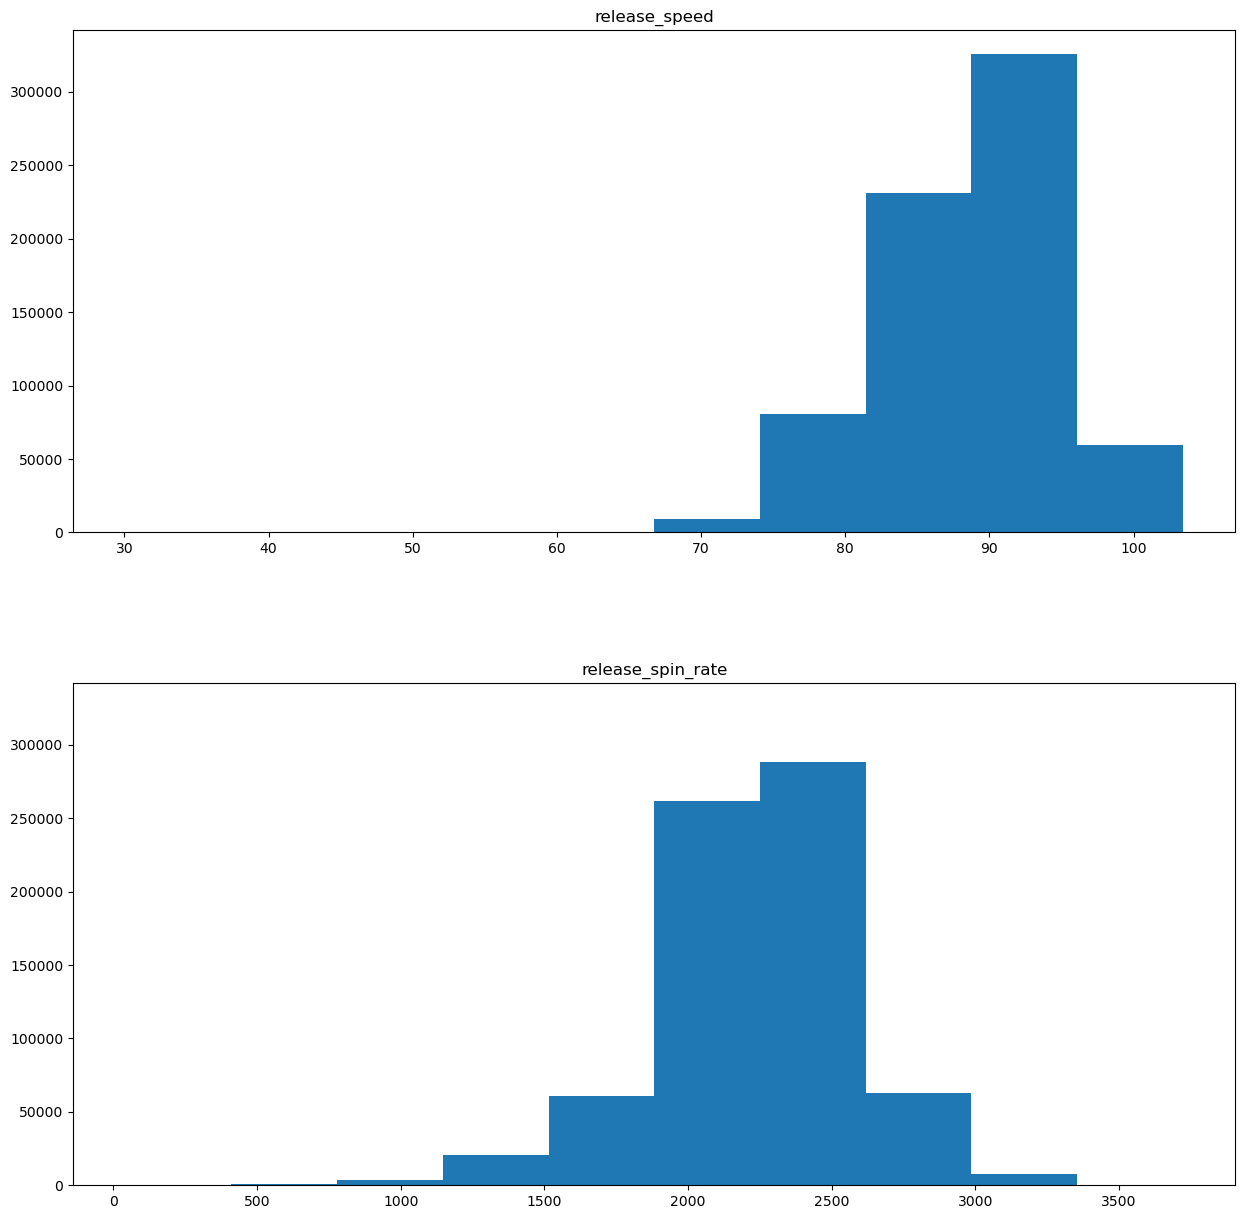

In [4]:
df.hist(column=["release_speed", "release_spin_rate"], layout=(2, 1), figsize=[15, 15], grid=False, sharey=True)

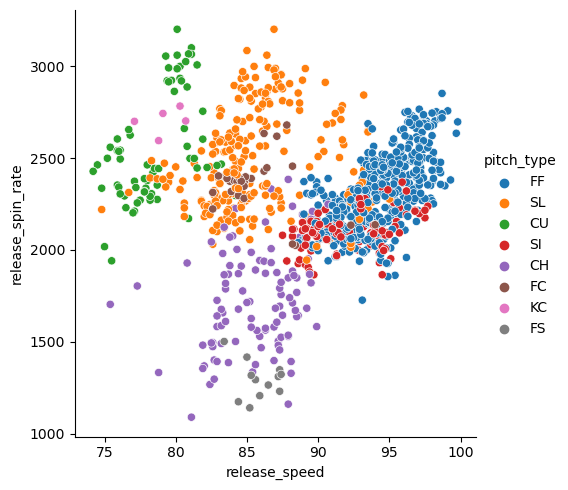

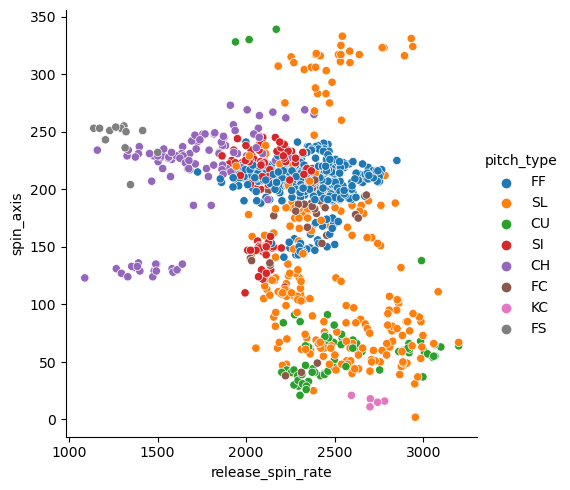

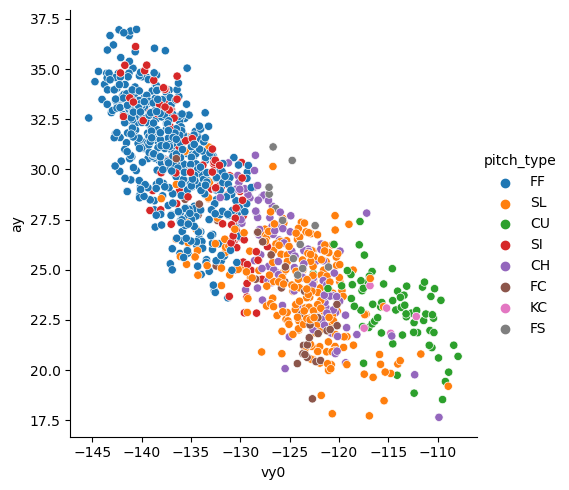

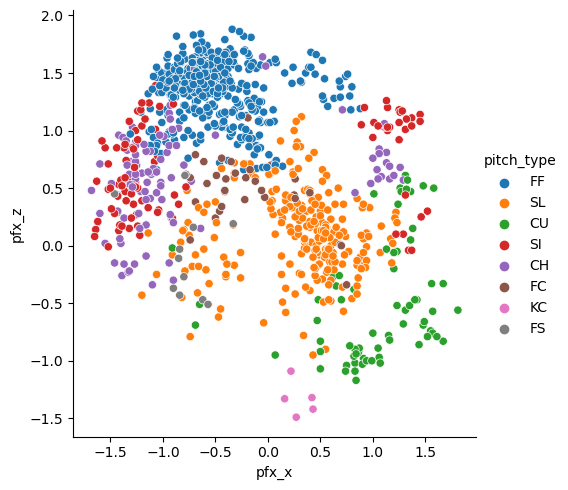

In [5]:
combinations = [('release_speed', 'release_spin_rate'), ('release_spin_rate', 'spin_axis'), ('vy0', 'ay'), ('pfx_x', 'pfx_z')]
for combo1, combo2 in combinations:
    sns.relplot(data=df.iloc[:1000, :], x=combo1, y=combo2, hue='pitch_type')
plt.show()

## Logistic Regression Classifier

In [ ]:
df_100 = df.head(100)

# loading x and y values
X = df.iloc[:, :-1].values.astype('object')
y = df["pitch_type"]

# Creating training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Implementing, fitting, and predicting of Logistic Regression Model
lr_model = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_model.fit(X_train, y_train)
y_pred = np.array((lr_model.predict(X_test)))

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Hyperparam tuning using GridSearch
grid_search = GridSearchCV(lr_model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Metrics of Logistic Regression model
print("Overall Score:")
print(lr_model.score(X_test, y_test))
print(f1_score(y_test, y_pred, average=None))
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))

## Random Forest Classifier

In [ ]:
model = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=10)
ground_truth = df.iloc[:, -1]
classes = pd.unique(ground_truth)

scores = {}
k = 10
for i in range(k):
    test_data = df.iloc[i * len(df) // k: (i + 1) * len(df) // k]
    train_data = pd.concat([df.iloc[0:i * len(df) // k], df.iloc[(i + 1) * len(df) // k:]])

    gt_data = []
    for i, item in train_data.iloc[:, -1].items():
        gt_data.append(np.where(classes == item)[0][0])

    model.fit(train_data.iloc[:, :-1], gt_data)

    predictions = model.predict(test_data.drop(['pitch_type'], axis=1))

    score = metrics.classification_report(test_data['pitch_type'], [classes[p] for p in predictions], digits=4, output_dict=True)
    average = score["weighted avg"]
    scores[i] = average


    print(f"Scores for Fold {i}: {average}")

mean_validated_scores = Counter()
for score in scores.values():
    mean_validated_scores["precision"] += score["precision"]
    mean_validated_scores["recall"] += score["recall"]
    mean_validated_scores["f1-score"] += score["f1-score"]
    
for key in mean_validated_scores.keys():
    mean_validated_scores[key] /= len(scores)
    
print(mean_validated_scores)

gt_data = []
for i, item in data.iloc[:, -1].items():
    gt_data.append(np.where(classes == item)[0][0])
model.fit(data.iloc[:, :-1], gt_data)

## KNN Classifier

In [ ]:
# Define features and target

X = df.iloc[:, :-1].values.astype('object')
y = df["pitch_type"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the testing data
y_pred = knn.predict(X_test)

# Metrics of Logistic Regression model
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## K-Means Classifier